# Evaluating Cartpole Model

In [1]:
# ---
# execute:
#     echo: true
# code-fold: true
# output: html
# toc: true
# fig-align: center
# fontsize: 16px
# format:
#     html:
#         embed-resources: true
# ---

In [2]:
#| output: false
## Environment and packages
# cd(@__DIR__)
# using Pkg; Pkg.activate("."); Pkg.instantiate()

using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Simulate Data from New Configuration

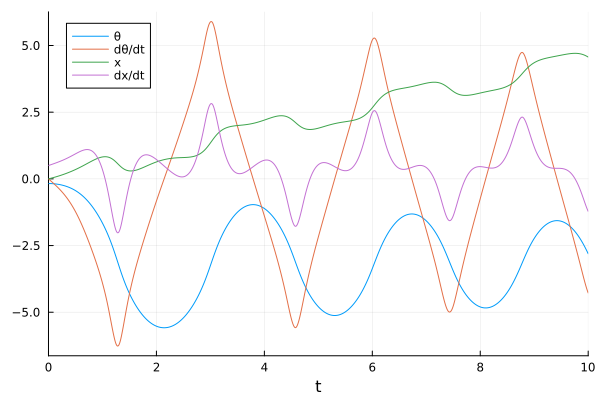

In [21]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
p = (1.5, 1.0, 9.8, 1.0, 0.05, 0.1, 1/3)

# Initial conditions
u0 = [-0.175, 0.0, 0.0, 0.5]  # 30 degrees, 0.5 m/s to the right
# u0 = [0.0, 3.0, 0.0, 2.0]  # Pend straight up (0 deg), moving 3 rad/s clockwise, cart moving 2 m/s to the left

tspan = (0.0,10.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol, label=["θ" "dθ/dt" "x" "dx/dt"])

## Use Chain to generate predictions


In [22]:
# path = "../../learnedModels/bayesianSindy/chain-cartpole-hs-hard-laplace-good.jls"
path = "../../learnedModels/bayesianSindy/chain-cartpole-stable3.jls"
chain = read(path, Chains);

In [23]:
#| output: false
function cartpoleSindy!(du, u, p, t)
     # u = [theta, theta_d, x, x_d]
 
     θ, θ̇, x, ẋ = u
 
     # Set epsilon for stability
     eps = 1e-3

     # theta_d and x_d
     du[1] = θ̇ #- eps*θ^3
     du[3] = ẋ - eps*x^3
 
     # theta_dd
     θ̈ = (p[1]*sin(θ) +
          p[2]*cos(θ) + 
          p[3]*θ̇ *sin(θ)+ 
          p[4]*ẋ *sin(θ)+ 
          p[5]*cos(θ) *sin(θ)+ 
          p[6]*ẋ *cos(θ)+ 
          p[7]*cos(θ) *θ̇ + 
          p[8]*cos(θ)^2+ 
          p[9]*sin(θ)^2+ 
          p[23]*θ̇+
          p[10] -
          eps*θ̇ ^3  # for stability
          )
     du[2] = θ̈ 
     
     # x_dd
     du[4] = (p[11]*sin(θ) +
              p[12]*cos(θ)+ 
              p[13]*θ̇ *sin(θ)+ 
              p[14]*ẋ *sin(θ)+ 
              p[15]*θ̈ *sin(θ)+ 
              p[16]*ẋ *cos(θ)+ 
              p[17]*cos(θ) *θ̇+ 
              p[18]*cos(θ) *sin(θ)+ 
              p[19]*cos(θ) *θ̈ + 
              p[20]*sin(θ)^2+ 
              p[21]*cos(θ)^2+ 
              p[24]*ẋ+
              p[22] -
              eps*ẋ^3  # for stability
              )
 end
cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:24])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 -0.175
  0.0
  0.0
  0.5

In [24]:
#| output: false
@model function genQuantities(::Type{T} = Float64) where {T <: Real}
    # Initialize theta
    priors = [Laplace(0.0, 0.1) for i in 1:24]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end    
    p = convert.(T, theta)
    
    # Initialize sigma
    σ ~ InverseGamma(2, 0.5)
    
    # Solve DE
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    # predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    # failure = size(predicted, 2) < length(t)

    # if failure
    #     Turing.@addlogprob! -Inf
    #     return
    # end

    return (; predicted_dense, theta)
end


genQuantities (generic function with 3 methods)

In [25]:
#| output: false
using DataFramesMeta

model = genQuantities()
finnish_chain = generated_quantities(model, MCMCChains.get_sections(chain, :parameters)[1:10, :, :])
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2));

In [26]:
# #| output: false
# using DataFrames

# # Extract coefficient samples

# # Clean data from generated quantites
# samples = size(finnish_chain, 1)
# var_str = [
#     "\$sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ)^2 \\rightarrow \\ddot{θ}\$",
#     "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
#     "\$sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) \\rightarrow \\ddot{x}\$",
#     "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} \\rightarrow \\ddot{x}\$",
#     "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * \\ddot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{x}\$", #placeholder
#     "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) * \\ddot{θ} \\rightarrow \\ddot{x}\$",
#     "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
#     "\$cos(θ)^2 \\rightarrow \\ddot{x}\$",
#     "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
#     "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
#     "\$const \\rightarrow \\ddot{x}\$",
#     "\$const \\rightarrow \\ddot{θ}\$",
# ]
# beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
# beta1[!,:var] = var_str
# beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
# beta1 = DataFrames.stack(beta1, 1:samples)
# beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
# beta2[!,:var] = var_str
# beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
# beta2 = DataFrames.stack(beta2, 1:samples)
# beta = vcat(beta1, beta2);

In [27]:
# #| output: false
# gd = groupby(beta, [:var, :chain])
# show(combine(gd, :value => mean), allrows=true)

$$
\ddot{\theta} = 6.35\sin{\theta} + 3.28\cos{\theta} -0.68\dot{\theta} + 3.3 \dot{x}
$$

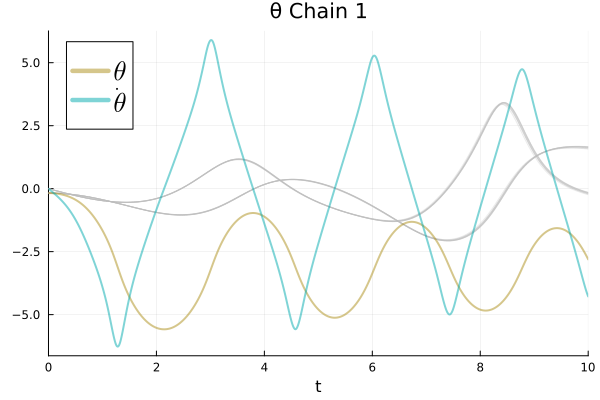

In [28]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:25:500
for i in 1:1:10
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, linecolor="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=2, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
# scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


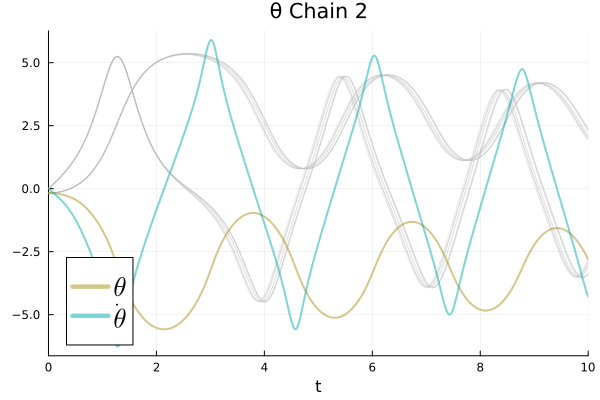

In [29]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 501:25:1000
for i in 11:1:20
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end


# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=2, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
# scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


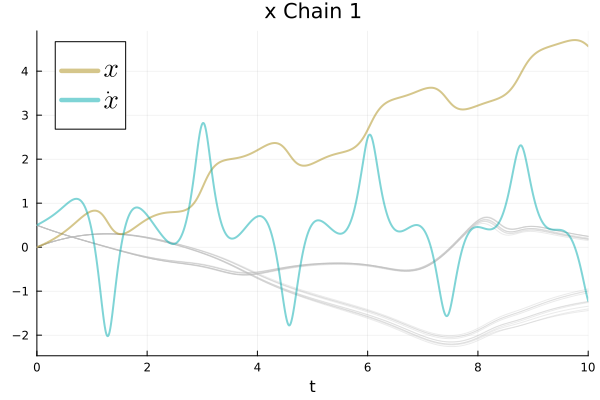

In [30]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:25:500
for i in 1:1:10
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=2, label=["\$x\$" "\$\\dot{x}\$"])
# scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


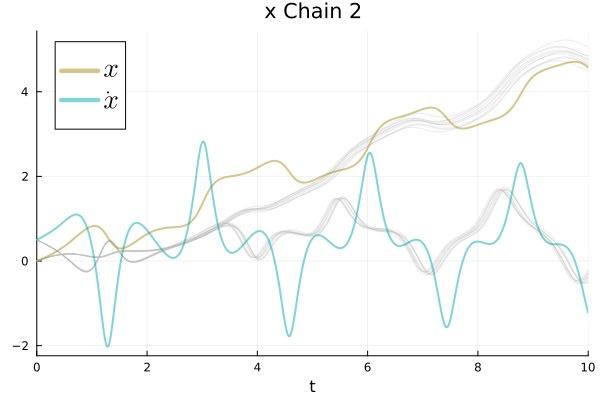

In [31]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 501:25:1000
for i in 11:1:20
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=2, label=["\$x\$" "\$\\dot{x}\$"])
# scatter!(t, odedata[3:4, :]'; color=[1 2], label="")
